##Third Iteration

**Changes:**
- Added DropOut at 2 places
- Using LRScheduler for deacaying the learning rate systematically.
- Change number of channels in initial blocks to 16 and 32.

**Expectations:**
- Expect a slight increase in accuracy because of LRScheduler
- Reduction in difference between the training and validation accuracy due to dropout.

**Result**:
- Parameters: 13,692
- Epochs Run: 50
- Best Epoch: 48
- Training Accuracy: 99.83
- Validation Accuracy: 99.32


In [0]:
# Install and Import Keras
# https://keras.io/
!pip install -q keras
import keras

In [0]:
# Importing the required libraries
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint

from keras.datasets import mnist

### Load pre-shuffled MNIST data into train and test sets

In [4]:
# Load MNIST into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [5]:
# Connecting Drive to save models
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


(60000, 28, 28)


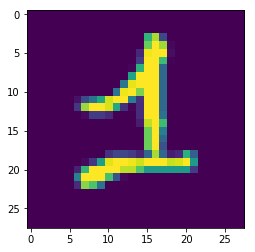

In [6]:
# Looking at sample images
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[24])

In [0]:
# Defining shape of the sets
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [0]:
# Scaling down pixel values from 0-255 to 0-1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [9]:
# Inspecting labels
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [11]:
# Inspectingt the categorized labels
Y_train[20:30]


array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [46]:
# Building the infrastructure
from keras.layers import Activation
model = Sequential()
 
model.add(Convolution2D(16, 3, activation='relu', input_shape=(28,28,1), name = "C3-1")) #26
model.add(BatchNormalization(name = "BN-C3-1"))
model.add(Convolution2D(32, 3, activation='relu', name = "C3-2")) #24
model.add(BatchNormalization(name = "BN-C3-2"))

model.add(Dropout(0.25, name = "DO-1"))

model.add(MaxPooling2D(2, name = "MP1")) #12

model.add(Convolution2D(16, 1, activation='relu', name = "C1-1")) #12
model.add(BatchNormalization(name = "BN-C1-1"))
model.add(Convolution2D(32, 3, activation='relu', name = "C3-3")) #10
model.add(BatchNormalization(name = "BN-C3-3"))

model.add(Dropout(0.25, name = "DO-2"))

model.add(MaxPooling2D(2, name = "MP2")) #5

model.add(Convolution2D(10, 1, activation='relu', name = "C1-2")) #5
model.add(BatchNormalization(name = "BN-C1-2"))
model.add(Convolution2D(16, 3, activation='relu', name = "C3-4")) #3
model.add(BatchNormalization(name = "BN-C3-4"))

model.add(Convolution2D(10, 3, name = "C20-1")) #1
model.add(Flatten(name = "F"))
model.add(Activation('softmax'))

# Checking the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C3-1 (Conv2D)                (None, 26, 26, 16)        160       
_________________________________________________________________
BN-C3-1 (BatchNormalization) (None, 26, 26, 16)        64        
_________________________________________________________________
C3-2 (Conv2D)                (None, 24, 24, 32)        4640      
_________________________________________________________________
BN-C3-2 (BatchNormalization) (None, 24, 24, 32)        128       
_________________________________________________________________
DO-1 (Dropout)               (None, 24, 24, 32)        0         
_________________________________________________________________
MP1 (MaxPooling2D)           (None, 12, 12, 32)        0         
_________________________________________________________________
C1-1 (Conv2D)                (None, 12, 12, 16)        528       
__________

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.003),
             metrics=['accuracy'])

In [0]:
#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
#early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('/content/gdrive/My Drive/EVA/P3/Try2/mnist.csv')

filepath="/content/gdrive/My Drive/EVA/P3/Try2/Iter3 - BestExp.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [50]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[csv_logger, checkpoint, LearningRateScheduler(scheduler, verbose=1)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
60000/60000 [==============================] - 40s 659us/step - loss: 0.1317 - acc: 0.9590 - val_loss: 0.1089 - val_acc: 0.9643

Epoch 00001: val_acc improved from -inf to 0.96430, saving model to /content/gdrive/My Drive/EVA/P3/Try2/Iter3 - BestExp.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
60000/60000 [==============================] - 36s 603us/step - loss: 0.0524 - acc: 0.9833 - val_loss: 0.0494 - val_acc: 0.9829

Epoch 00002: val_acc improved from 0.96430 to 0.98290, saving model to /content/gdrive/My Drive/EVA/P3/Try2/Iter3 - BestExp.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
60000/60000 [==============================] - 36s 607us/step - loss: 0.0421 - acc: 0.9863 - val_loss: 0.0608 - val_acc: 0.9797

Epoch 00003: val_acc did not improve from 0.98290
Epoch 4

In [0]:
# Loading best model from the initial training
model.load_weights("/content/gdrive/My Drive/EVA/P3/Try2/Iter3 - BestExp.hdf5")

In [0]:
# Evaluating the model on the test data
score = model.evaluate(X_test, Y_test, verbose=0)

In [45]:
# Printing test score
print(score)

[0.03576093653029134, 0.9921]
